# **RANSAC**

**Required Reading**

[Prince Computer Vision Chapter 15.6](http://www.computervisionmodels.com/)

** Relevant Documentation **
- [Camera Calibration and 3d Reconstruction](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

---

**Recommended** [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

and for presenting:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

---

- Computer Vision algorithms are noisy. 
- When we fit models to data we need robust methods for handling outliers/errors. 
- For example, in our discussion Interest Points, we discussed the ORB detector + descriptor. 
- ORB performed well, but like most keypoint algorithms, did suffer from outliers:

![](../videos/orb.gif)

- The big idea here is that by fitting a model to a subset of our keypoints, we can use random sample consensus (RANSAC) to reject false matches. 
- Let's go ahead and load up 2 example frames:

In [1]:
%pylab inline
import cv2

im1 = imread('../data/small/image_00.jpg')
gray_1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

Populating the interactive namespace from numpy and matplotlib


In [2]:
im2 = imread('../data/small/image_03.jpg')
gray_2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

In [3]:
ORB = cv2.ORB_create(nfeatures = 2000)

kpts1, des1 = ORB.detectAndCompute(gray_1, None)
kpts2, des2 = ORB.detectAndCompute(gray_2, None)

In [4]:
#create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

#Perform Matching, return 2 closest matches:
matches = bf.knnMatch(des1, des2, k=2)

In [5]:
# Apply lowes' ratio test
matches_cleaned = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        matches_cleaned.append(m)

In [6]:
matches_cleaned = sorted(matches_cleaned, key = lambda x:x.distance)

In [7]:
matching_keypoints_1 = []
matching_keypoints_2 = []

for match in matches_cleaned:
    matching_keypoints_1.append(kpts1[match.queryIdx])
    matching_keypoints_2.append(kpts2[match.trainIdx])

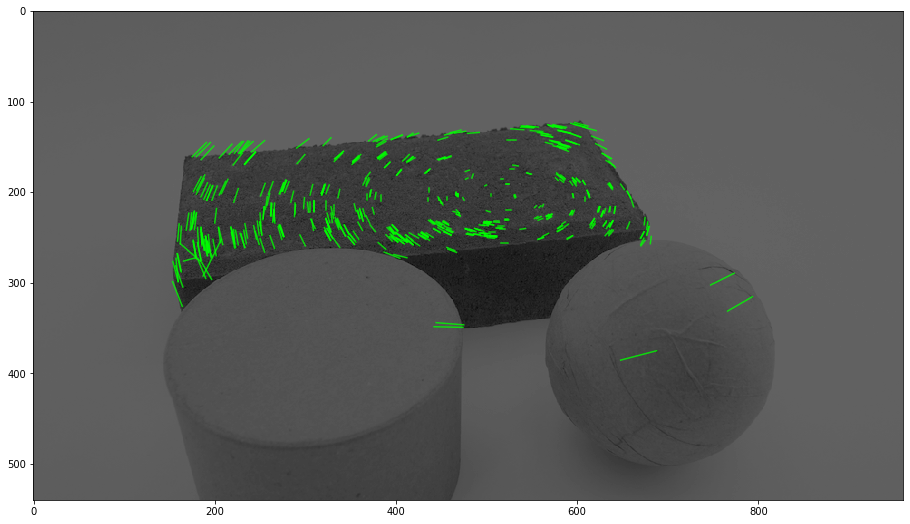

In [8]:
fig = figure(0, (22, 9))
imshow(gray_2*0.4, cmap = 'gray', vmax = 255, vmin = 0) #Darken image to make it easier to see flow lines

for i in range(len(matching_keypoints_1)):
    plot([matching_keypoints_1[i].pt[0], matching_keypoints_2[i].pt[0]],
         [matching_keypoints_1[i].pt[1], matching_keypoints_2[i].pt[1]], alpha = 0.8, c = (0, 1, 0))

## **Can we get rid of the false matches?**

- Let's discuss the motivation behind RANSAC.

![](../graphics/prince_ransac_one-01.png)

- The RANSAC method itself is pretty simple, here's how it works:

![](../graphics/prince_ransac_two-01.png)

## Alright, let's try it!

- One item we've skipped over thusfar is what model we'll be fitting to our data.
- Since our points represent two different viewpoints of a 3d scene, we can't use any of the 2d transformation models we discussed in the transformations notebook. 
- Instead, we'll use a fundamental matrix model, as discussed in the 3d reconsruction lecture and Prince computer vision chapter 16.
- Fitting a fundamental matrix to our data is less specific than a homography - homographies exactly map points from one image to another, while a fundamental matrix just tells us the epipolar line a given point in one image will fall on in the other. 
- We'll use the opencv method `findFundamentalMat` to both fit the the model and implement the RANSAC method.

In [9]:
p1 = []
p2 = []

for i in range(len(matching_keypoints_1)):
    p1.append([matching_keypoints_1[i].pt[0], matching_keypoints_1[i].pt[1]])
    p2.append([matching_keypoints_2[i].pt[0], matching_keypoints_2[i].pt[1]])
    
p1 = np.array(p1)
p2 = np.array(p2)    

In [10]:
f, inliers =  cv2.findFundamentalMat(points1 = p1, 
                                     points2 = p2, 
                                     method = cv2.FM_RANSAC,
                                     ransacReprojThreshold = 2.0)

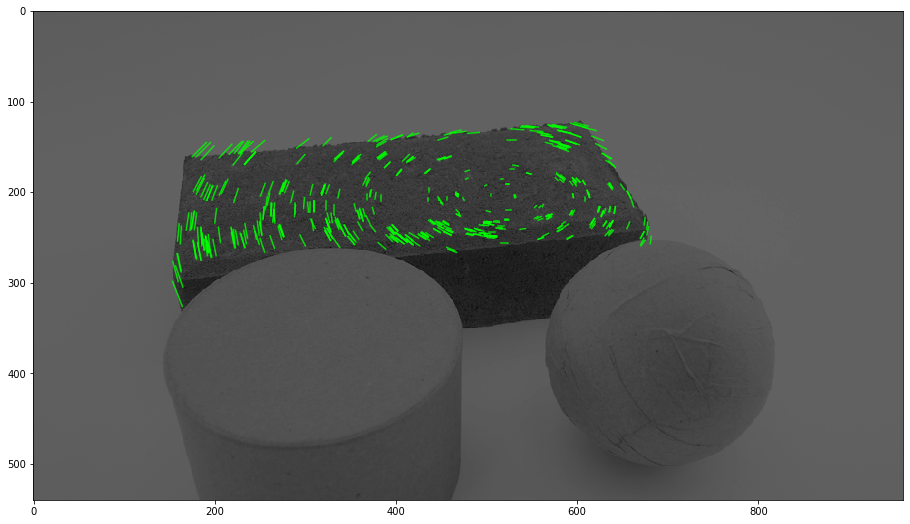

In [11]:
fig = figure(0, (22, 9))
imshow(gray_2*0.4, cmap = 'gray', vmax = 255, vmin = 0) #Darken image to make it easier to see flow lines

for i in range(len(matching_keypoints_1)):
    if inliers[i]:
        plot([matching_keypoints_1[i].pt[0], matching_keypoints_2[i].pt[0]],
             [matching_keypoints_1[i].pt[1], matching_keypoints_2[i].pt[1]], 
              alpha = 0.8, 
              c = (0, 1, 0))

## Way less false matches! 